<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Convolutional-Neural-Networks-in-Python/blob/master/fer_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
import theano.tensor as T
import theano

In [0]:
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

In [0]:
def optimizer_update_momentum(cost, parameters, lr, mu=0.9):
  mu = np.float32(mu)
  grads = T.grad(cost, parameters)
  updates = []
  for p, g in zip(parameters, grads):
    # momentum
	  zeros = np.zeros_like(p.get_value(), dtype=np.float32)
	  m = theano.shared(zeros)
	  new_m = mu*m - lr*g

		# param update
	  update_p = p + new_m

		# append the updates
	  updates.append((p, update_p))
    
  return updates

In [0]:
def init_filter(shape):
  w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[1:]))
  return w.astype(np.float32)

In [0]:
class convpool():
  def __init__(self, num_feature_maps, num_color_channels, filter_width, filter_height, poolsz=(2, 2)):
    self.poolsz = poolsz
    sz = (num_feature_maps, num_color_channels, filter_width, filter_height)
    W = init_filter(sz)
    b = np.zeros(num_feature_maps, dtype=np.float32)
    
    self.W = theano.shared(W)
    self.b = theano.shared(b)
    
    self.params = [self.W, self.b]
    
  def convpool_forward(self, X):
    conv_out = conv2d(input=X, filters=self.W)
    
    # downsample each feature map individually, using maxpooling
    pooled_out = pool.pool_2d(
        input=conv_out,
        ws=self.poolsz,
        ignore_border=True,
        mode='max',
    )
    return T.nnet.relu(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [0]:
class HiddenLayer():
  def __init__(self, D, M):
    W = np.random.randn(D, M) / np.sqrt(D)
    b = np.zeros(M)
    
    self.W = theano.shared(W.astype(np.float32))
    self.b = theano.shared(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def forward(self, X):
    return T.nnet.relu(X.dot(self.W)+self.b)

In [0]:
class FinalLayer():
  def __init__(self, M, K):
    W = np.random.randn(M, K) / np.sqrt(M)
    b = np.zeros(K)
    
    self.W = theano.shared(W.astype(np.float32))
    self.b = theano.shared(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def forward(self, Z):
    return T.nnet.softmax(Z.dot(self.W)+self.b)

In [0]:
class CNN():
  def __init__(self, filter_layer_sizes, hidden_layer_sizes):
    self.filter_layer_sizes = filter_layer_sizes
    self.hidden_layer_sizes = hidden_layer_sizes
    
  def fit(self, X, Y, lr=1e-1, reg=0.01, training_epochs=3, batch_sz=30):
    
    lr = np.float32(lr)
    reg = np.float32(reg)
    
    X, Y = shuffle(X, Y)
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    
    Xtrain, Ytrain = X[:-1000], Y[:-1000]
    Xtest, Ytest = X[-1000:], Y[-1000:]
    
    #print(Xtrain.shape)              (39263, 1, 48, 48)
    #print(Xtest.shape)               (1000, 1, 48, 48)

    N = Xtrain.shape[0]    
    K = len(set(Ytrain))
    
    num_color_channels = Xtrain.shape[1]
    image_w = Xtrain.shape[2]
    image_h = Xtrain.shape[3]
    
    self.convpool_layers = []
    for num_feature_maps, filter_width, filter_height in self.filter_layer_sizes:
      c = convpool(num_feature_maps, num_color_channels, filter_width, filter_height)
      self.convpool_layers.append(c)
      num_color_channels = num_feature_maps
      image_w = (image_w - filter_width + 1) // 2
      image_h = (image_h - filter_height + 1) // 2
    
    X = T.tensor4('X', dtype='float32')
    Y = T.ivector('Y')
    
    self.parameters = []
    
    for obj in self.convpool_layers:
      self.parameters += obj.params
    
    self.layers = []
    M1 = num_feature_maps * image_w * image_h     # This is now 20 * 9 * 9 = 1620
    for M2 in self.hidden_layer_sizes:
      h = HiddenLayer(M1, M2)
      self.layers.append(h)
      M1 = M2
    
    f = FinalLayer(M1, K)
    self.layers.append(f)
    
    for obj in self.layers:
      self.parameters += obj.params
    
    # forward pass
    pY = self.th_forward(X)
    
    rcost = reg*T.sum([(p*p).sum() for p in self.parameters])
    cost = -T.mean(T.log(pY[T.arange(Y.shape[0]), Y]))
    
    updates = optimizer_update_momentum(cost, self.parameters, lr)
    
    train_op = theano.function(inputs=[X,Y], updates=updates)
    
    prediction = T.argmax(pY, axis=1)

    test_op = theano.function(inputs=[X,Y], outputs=[cost, prediction])
    
    n_batches = N // batch_sz
    costs = []
    
    for epoch in range(training_epochs):
      Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_op(Xbatch, Ybatch)
        
        if j % 20 == 0:
          c, p = test_op(Xtest, Ytest)
          costs.append(c)
          e = np.mean(p != Ytest)
          print("Epoch", (epoch + 1), "Batch", j, ": cost =", "%.2f" % c, "error rate =", "%.2f" % e)
          
    plt.plot(costs, label="cost")
    plt.legend()
    plt.show()
    
  def th_forward(self, X):
    Z = X
    for obj in self.convpool_layers:
      Z = obj.convpool_forward(Z)
    Z = Z.flatten(ndim=2)
    for obj in self.layers:
      Z = obj.forward(Z)
    return Z
#     for obj in self.layers[:-1]:
#       Z = obj.HiddenLayer_forward(Z)
#     for obj in self.layers[-1:]:
#       pY = obj.FinalLayer_forward(Z)
#     return pY

Mounted at /content/gdrive
Epoch 1 Batch 0 : cost = 2.25 error rate = 0.79
Epoch 1 Batch 20 : cost = 1.93 error rate = 0.77
Epoch 1 Batch 40 : cost = 1.91 error rate = 0.77
Epoch 1 Batch 60 : cost = 1.91 error rate = 0.77
Epoch 1 Batch 80 : cost = 1.91 error rate = 0.77
Epoch 1 Batch 100 : cost = 1.90 error rate = 0.77
Epoch 1 Batch 120 : cost = 1.90 error rate = 0.77
Epoch 1 Batch 140 : cost = 1.89 error rate = 0.77
Epoch 1 Batch 160 : cost = 1.89 error rate = 0.76
Epoch 1 Batch 180 : cost = 1.90 error rate = 0.76
Epoch 1 Batch 200 : cost = 1.87 error rate = 0.73
Epoch 1 Batch 220 : cost = 1.89 error rate = 0.79
Epoch 1 Batch 240 : cost = 1.85 error rate = 0.72
Epoch 1 Batch 260 : cost = 1.83 error rate = 0.73
Epoch 1 Batch 280 : cost = 1.83 error rate = 0.73
Epoch 1 Batch 300 : cost = 1.79 error rate = 0.70
Epoch 1 Batch 320 : cost = 1.81 error rate = 0.73
Epoch 1 Batch 340 : cost = 1.82 error rate = 0.69
Epoch 1 Batch 360 : cost = 1.76 error rate = 0.66
Epoch 1 Batch 380 : cost = 1.

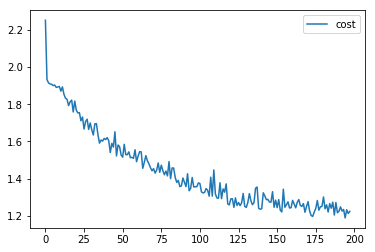

In [70]:
def main():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount = True)
  
  Y = []
  X = []
  first = True
  for line in open('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/fer2013.csv'):
    if first:
      first = False
    else:
      row = line.split(',')
      Y.append(int(row[0]))
      X.append([int(p) for p in row[1].split()])

  X, Y = np.array(X) / 255.0, np.array(Y)

  # balance the 1 class
  X0, Y0 = X[Y!=1, :], Y[Y!=1]
  X1 = X[Y==1, :]
  X1 = np.repeat(X1, 9, axis=0)
  X = np.vstack([X0, X1])
  Y = np.concatenate((Y0, [1]*len(X1)))
  
  N,D = X.shape
  d = int(np.sqrt(D))
  X = X.reshape(N, 1, d, d)
  
  model = CNN(
      filter_layer_sizes = [(20, 5, 5), (20, 5, 5)],
      hidden_layer_sizes = [500, 300],
  )
  
  model.fit(X, Y)
  
if __name__ == '__main__':
  main()